In [2]:
from processing_utils import DataPrepare
from studu_utils import load_best_global, save_best_global, plot_feature_premutation_importance, plot_predictions, permutation_feature_importance_ranker, prepare_data_for_ranker


import polars as pl
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRanker, Pool, cv

In [3]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\dfs\2024-06-29 20-00-00_2024-07-01 00-00-00_delta_0-00-10_return_5_sec.parquet')
target_var: str = "log_return"
cols_to_exclude: list[str] = []
# File to store the best global results
BEST_GLOBAL_FILE = "best_global_CBR.json"
cat_features = ['currency_pair']
group_id =  "cross_section_id" #should be a name of column containing info about crossection ID

In [4]:
data = DataPrepare(df)

In [5]:
data.train_test_split(train_test_ratio=0.7, exclude_columns=None)
X_train, y_train, X_test, y_test, = data.X_y_split(target_var=target_var, target_encode=False, to_pandas=True)

Train test ratio is 0.7
Train len for AVAXUSDT is 5763
Test len for AVAXUSDT is 2470
Train len for DOGEUSDT is 6664
Test len for DOGEUSDT is 2856


In [6]:
# Initialize best global results
best_global = load_best_global(BEST_GLOBAL_FILE)

In [7]:
def objective(trial, X_train, y_train, features):
    # Store the features in trial user attributes
    trial.set_user_attr("features", features)

    # Define hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": trial.suggest_categorical("loss_function", ["YetiRank", "YetiRankPairwise"]),
        "random_seed": 42,
        "logging_level": "Silent",  # Suppress internal logs during CV
        "early_stopping_rounds": 50 
    }

    train_pool = prepare_data_for_ranker(X_train=X_train, 
                                        y_train=y_train,
                                        group_id=group_id,
                                        cat_features=cat_features)

    # Perform cross-validation using CatBoost's cv method
    cv_results = cv(
        pool=train_pool,
        params=params,
        fold_count=2,  # Number of cross-validation folds
        partition_random_seed=42,
        shuffle=True,
        verbose=False
    )
    #print("cv_results:", cv_results)

    # Extract the best cross-validated metric
    mean_ndcg_loss = np.max(cv_results["test-NDCG:type=Base-mean"])  # Use actual metric key from cv_results

    return mean_ndcg_loss

In [8]:
def optimize_with_dataset(X_train, y_train, study_name=None):
    global best_global

    features = list(X_train.columns)

    if study_name:
        pass
    if features == best_global["features"]:
        study_name = best_global["study_name"]
    else:
        study_name = datetime.now().strftime("study_%Y-%m-%d_%H-%M-%S")
    

    # Create a new study
    study = optuna.create_study(
        study_name=study_name,
        storage="sqlite:///optuna_study_CB.db",
        direction="minimize",
        load_if_exists=True
    )

    # Run optimization
    study.optimize(lambda trial: objective(trial, X_train, y_train, features), n_trials=1)

    # Update the global best result if the current study has a better score
    if study.best_value < best_global["best_value"]:
        best_global.update(
            {
                "study_name": study_name,
                "best_value": study.best_value,
                "best_params": study.best_params,
                "features": features,
            }
        )
        # Save the updated best global results to disk
        save_best_global(best_global, BEST_GLOBAL_FILE)

    print(f"Study: {study_name}")
    print(f"Best Value: {study.best_value}")
    print(f"Best Params: {study.best_params}")

    return study


In [9]:
study = optimize_with_dataset(X_train, y_train)

[I 2024-12-20 15:03:19,733] Using an existing study with name 'study_2024-12-20_13-11-34' instead of creating a new one.
Implicitly assume bayesian bootstrap, learning could be slower
Implicitly assume bayesian bootstrap, learning could be slower
Implicitly assume bayesian bootstrap, learning could be slower
[I 2024-12-20 15:03:23,096] Trial 1 finished with value: 0.9481248261652133 and parameters: {'iterations': 1853, 'learning_rate': 0.011745752065255648, 'depth': 5, 'l2_leaf_reg': 1.1028482274926983, 'bagging_temperature': 5.027077328850473, 'colsample_bylevel': 0.85202314422938, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 18, 'loss_function': 'YetiRankPairwise'}. Best is trial 1 with value: 0.9481248261652133.


Study: study_2024-12-20_13-11-34
Best Value: 0.9481248261652133
Best Params: {'iterations': 1853, 'learning_rate': 0.011745752065255648, 'depth': 5, 'l2_leaf_reg': 1.1028482274926983, 'bagging_temperature': 5.027077328850473, 'colsample_bylevel': 0.85202314422938, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 18, 'loss_function': 'YetiRankPairwise'}


In [ ]:
# To open dashbourd run this:
!optuna-dashboard sqlite:///optuna_study_CB.db

# And listen to:
# http://localhost:8080/

Implicitly assume bayesian bootstrap, learning could be slower
Implicitly assume bayesian bootstrap, learning could be slower
Implicitly assume bayesian bootstrap, learning could be slower
Implicitly assume bayesian bootstrap, learning could be slower


Best NDCG: 0.9369 at iteration 558


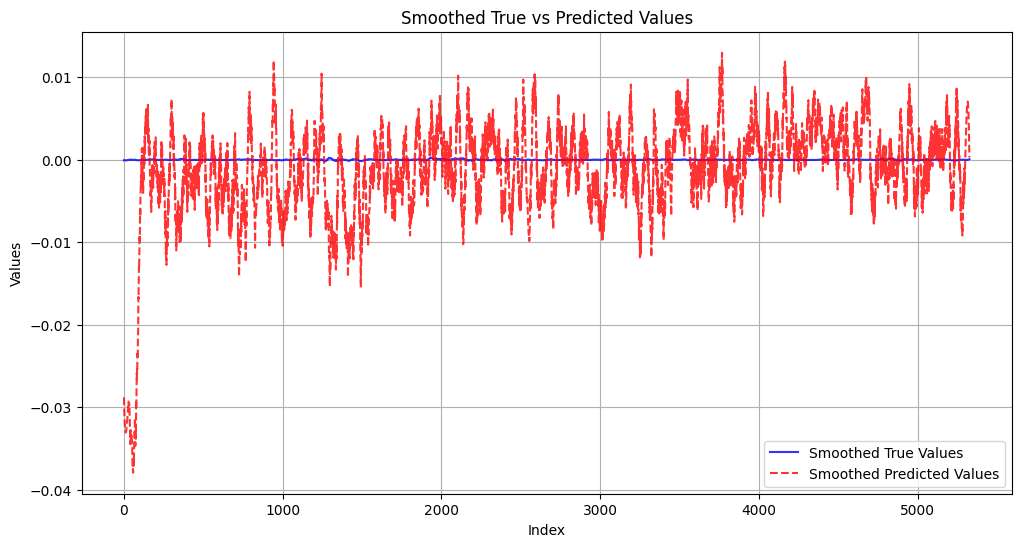

In [11]:
ranker_model = CatBoostRanker(**study.best_params)
train_pool = prepare_data_for_ranker(X_train=X_train, 
                                        y_train=y_train,
                                        group_id=group_id,
                                        cat_features=cat_features)
ranker_model.fit(train_pool, verbose=False)

test_pool = prepare_data_for_ranker(X_train=X_test, 
                                        y_train=y_test,
                                        group_id=group_id,
                                        cat_features=cat_features)

# Note that preds here is scores of relative importance of item within a ranking context. 
# It is not returns.
# Although this scores are correlated with returns obviously.
preds = ranker_model.predict(test_pool)

metrics = ranker_model.eval_metrics(
    data=test_pool,
    metrics=["NDCG"],
    ntree_start=0,
    ntree_end=ranker_model.tree_count_,
    eval_period=1
)

# Extract and analyze NDCG
ndcg_values = metrics["NDCG:type=Base"]
best_ndcg = max(ndcg_values)
best_iteration = ndcg_values.index(best_ndcg)

print(f"Best NDCG: {best_ndcg:.4f} at iteration {best_iteration}")
plot_predictions(y_test, y_pred=preds)

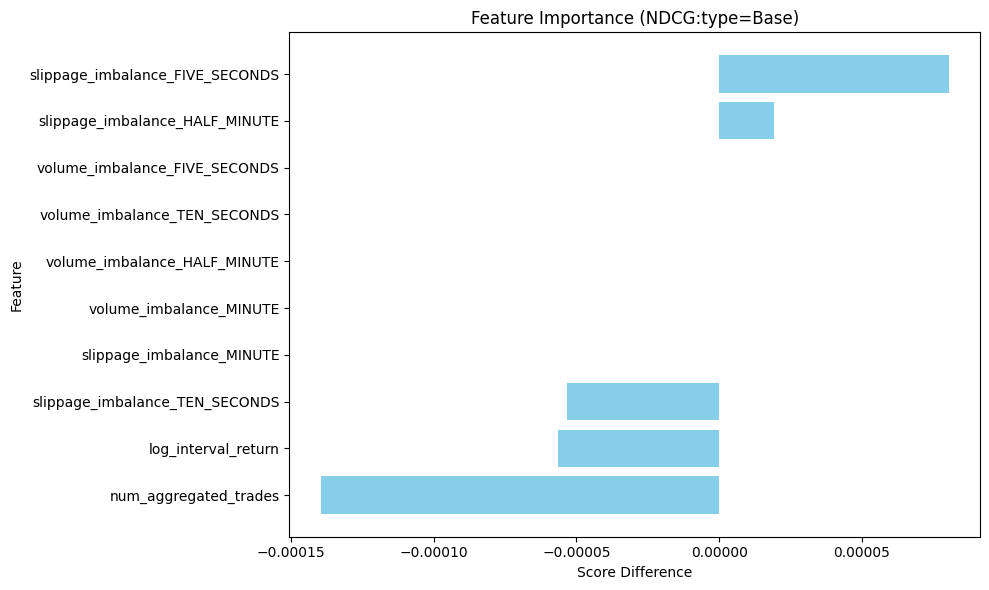

In [12]:
results = permutation_feature_importance_ranker(ranker_model=ranker_model, X_test=X_test, y_test=y_test, group_id=group_id,cat_features=cat_features, metric="NDCG:type=Base")
plot_feature_premutation_importance(results)